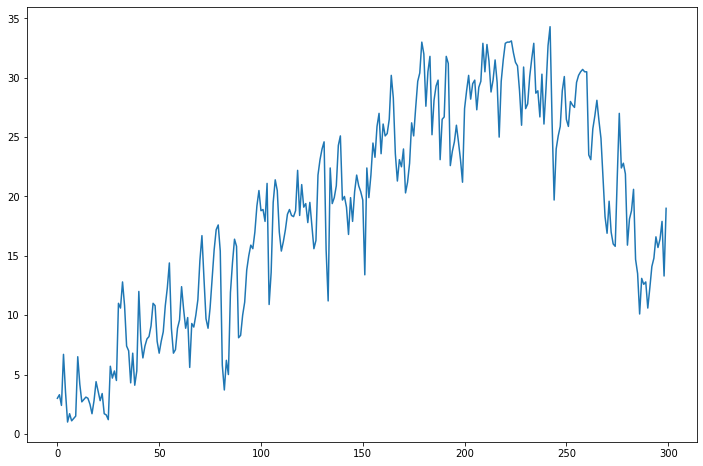

In [187]:
# In this cell we load the csv data and parse them.
# The csv files contain the min and max temperature for each month in the year
# of 2020 (up to oktober 27th)
# This data will be used to predict for the following days:
# 301th day
# 308th day
# 329th day

import numpy as np
from numpy import genfromtxt

# For storing the .csv filenames
list_of_files = ['_01.csv',
                 '_02.csv',
                 '_03.csv',
                 '_04.csv',
                 '_05.csv',
                 '_06.csv',
                 '_07.csv',
                 '_08.csv',
                 '_09.csv',
                 '_10.csv',
                 ]

# Parsing the data
i = 0
for files in list_of_files:
  if i == 0:
    all_data = genfromtxt(list_of_files[i], delimiter=';')
  else:
    all_data = np.concatenate((all_data, genfromtxt(list_of_files[i], delimiter=';') ))
  i = i + 1

# all_data[:, 1] is the max temperature
# all_data[:, 2] is the min temperature
# This time around we only use the max temperature data
X = all_data[:, 1]
X = np.atleast_2d(X)

# Plotting the temperature data
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 8))
plt.plot(X[0][:])

In [188]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD


# <--- Function definitions --->
# Creating the required timeseries data
def make_timeseries_instances(timeseries, windows_size):
  timeseries = np.asarray(timeseries)
  assert 0 < windows_size < timeseries.shape[0], "Out of range 0 < {} < {}".format(windows_size, timeseries.shape[0])
  X = np.atleast_3d( np.array(  [timeseries[start:start + windows_size] for start in range(0, timeseries.shape[0] - windows_size)]  )  )
  Y = timeseries[windows_size:]
  return X, Y

# Creating the 1D convolutional network model
def make_1d_convnet(windows_size, filter_length, nb_input_series = 1, nb_outputs = 1, nb_filter = 4):
  model = Sequential()
  model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu', input_shape = (windows_size, nb_input_series)))
  model.add(MaxPooling1D())
  model.add(Conv1D(filters = nb_filter, kernel_size = filter_length, activation = 'relu'))
  model.add(Flatten())
  model.add(Dense(nb_outputs, activation = 'linear'))
  model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])
  return model

# Function for training our 1D CNN network
def train_cnn(timeseries, window_size, valid_split = 0.15, test_split = 0):
  filter_length = 5
  nb_filter = 4
  timeseries = np.atleast_2d(timeseries)
  if timeseries.shape[0] == 1:
    timeseries = timeseries.T
  nb_samples, nb_series = timeseries.shape
  model = make_1d_convnet(windows_size = window_size, filter_length = filter_length, nb_input_series = nb_series, nb_outputs = nb_series, nb_filter = nb_filter)

  X, Y = make_timeseries_instances(timeseries, window_size)
  valid_size = int(nb_samples*(1-test_split-valid_split))
  test_size = int(nb_samples*(1-test_split))
  X_train, Y_train = X[:valid_size], Y[:valid_size]
  X_valid, Y_valid = X[valid_size:test_size], Y[valid_size:test_size]
  X_test, Y_test   = X[test_size:], Y[test_size:]

  model.fit(X_train, Y_train, epochs = 50, batch_size = 16, verbose = 2)
  return model

# Rekurent predictions
def one_step_prediction(model, X):
  Y = model.predict(np.atleast_3d(X))
  return Y

# Appending the newly generated prediction to the test data (and truncating its first value)
def generate_X(old_X, Y, windows_size = 20):
  old_X = old_X[:, -(windows_size-1):, :]
  new_X = np.append(old_X, Y)
  new_X = np.atleast_3d(new_X)
  return new_X

In [189]:
# Training
window_size = 20
model = train_cnn(X, window_size)

Epoch 1/50
16/16 - 0s - loss: 399.4556 - mae: 18.2614
Epoch 2/50
16/16 - 0s - loss: 275.8351 - mae: 15.1363
Epoch 3/50
16/16 - 0s - loss: 185.6677 - mae: 12.2607
Epoch 4/50
16/16 - 0s - loss: 100.1840 - mae: 8.7825
Epoch 5/50
16/16 - 0s - loss: 39.3791 - mae: 5.2602
Epoch 6/50
16/16 - 0s - loss: 17.6408 - mae: 3.4085
Epoch 7/50
16/16 - 0s - loss: 16.2975 - mae: 3.2001
Epoch 8/50
16/16 - 0s - loss: 16.2199 - mae: 3.1958
Epoch 9/50
16/16 - 0s - loss: 16.1456 - mae: 3.2160
Epoch 10/50
16/16 - 0s - loss: 16.0456 - mae: 3.2115
Epoch 11/50
16/16 - 0s - loss: 16.0265 - mae: 3.1981
Epoch 12/50
16/16 - 0s - loss: 16.0317 - mae: 3.2105
Epoch 13/50
16/16 - 0s - loss: 15.9821 - mae: 3.2058
Epoch 14/50
16/16 - 0s - loss: 16.0301 - mae: 3.1984
Epoch 15/50
16/16 - 0s - loss: 15.9514 - mae: 3.1950
Epoch 16/50
16/16 - 0s - loss: 15.9097 - mae: 3.1951
Epoch 17/50
16/16 - 0s - loss: 15.9016 - mae: 3.1962
Epoch 18/50
16/16 - 0s - loss: 15.9068 - mae: 3.1931
Epoch 19/50
16/16 - 0s - loss: 15.8483 - mae: 3.

Prediction for október 28.:  13.907818794250488
Prediction for november 3.:  16.244935989379883
Prediction for november 24.:  15.17946720123291


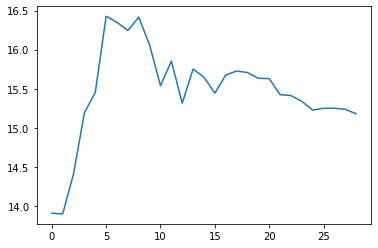

In [191]:
# Predicting one day ahead, iteratively
new_X = X[:,-20:]
Y_predictions = np.ndarray(0)
for i in range(0, 29):
  new_X = np.atleast_3d(new_X)
  Y = one_step_prediction(model, new_X)
  Y_predictions = np.append(Y_predictions, Y[0])
  new_X = generate_X(old_X = new_X, Y = Y)

# print(Y_predictions)
plt.plot(Y_predictions)

# We have the data for 300 previos days in the year
# The question is:
# 301th day
# 308th day
# 329th day

print("Prediction for október 28.: " , Y_predictions[0])
print("Prediction for november 3.: " , Y_predictions[7])
print("Prediction for november 24.: " , Y_predictions[28])







